<a href="https://colab.research.google.com/github/hvmdvvn/Pytorch-Projects/blob/main/Animal_Faces_Multi_Class_Classifier_Pytorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hvmdvvn
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:11<00:00, 65.9MB/s]


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder # ouput str -> int

import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
image_path = []
labels = []

for i in os.listdir(f"/content/animal-faces/afhq/"):
  # print(i)
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    # print(label)
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      # print(image)
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

df = pd.DataFrame(zip(image_path, labels), columns=['image_path', "labels"])
df.head()


,image_path,labels
0,/content/animal-faces/afhq/train/dog/flickr_do...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [4]:
print(df["labels"].unique())

['dog' 'cat' 'wild']


In [5]:
train = df.sample(frac=0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(df["labels"])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

In [7]:
class CustomImageDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(df["labels"])).to(device)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    image_path = self.df.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(image_path).convert("RGB")

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [8]:
train_dataset = CustomImageDataset(df = train, transform=transform)
val_dataset = CustomImageDataset(df = val, transform=transform)
test_dataset = CustomImageDataset(df = test, transform=transform)

In [9]:
train_dataset.__len__()

11291

In [10]:
train_dataset.__getitem__(2)

(tensor([[[0.5451, 0.5412, 0.5294,  ..., 0.4549, 0.4588, 0.4627],
          [0.5255, 0.5176, 0.5137,  ..., 0.4627, 0.4627, 0.4667],
          [0.5020, 0.4941, 0.4902,  ..., 0.4824, 0.4745, 0.4745],
          ...,
          [0.3137, 0.3059, 0.3098,  ..., 0.6784, 0.6706, 0.6392],
          [0.3255, 0.3216, 0.3216,  ..., 0.6431, 0.6471, 0.6353],
          [0.3255, 0.3294, 0.3294,  ..., 0.5882, 0.6314, 0.6314]],
 
         [[0.5216, 0.5255, 0.5255,  ..., 0.4510, 0.4588, 0.4627],
          [0.4980, 0.5020, 0.5098,  ..., 0.4588, 0.4627, 0.4667],
          [0.4745, 0.4745, 0.4863,  ..., 0.4784, 0.4745, 0.4745],
          ...,
          [0.3725, 0.3647, 0.3686,  ..., 0.4392, 0.4431, 0.4196],
          [0.3843, 0.3804, 0.3804,  ..., 0.4039, 0.4157, 0.4000],
          [0.3843, 0.3882, 0.3882,  ..., 0.3647, 0.4157, 0.4039]],
 
         [[0.4706, 0.4745, 0.4745,  ..., 0.4314, 0.4275, 0.4275],
          [0.4627, 0.4627, 0.4588,  ..., 0.4392, 0.4314, 0.4314],
          [0.4588, 0.4510, 0.4431,  ...,

In [11]:
label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

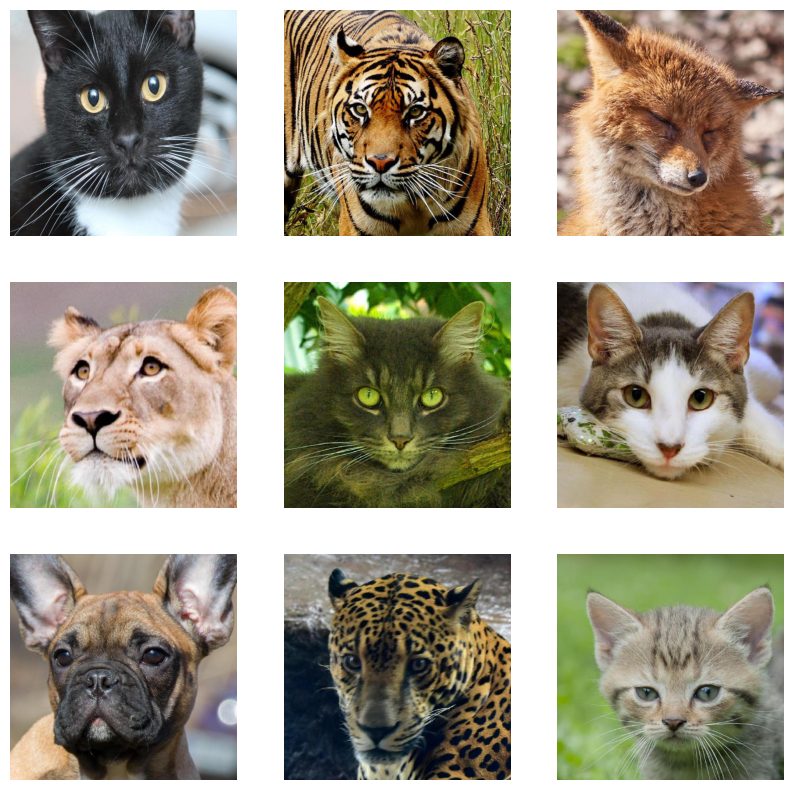

In [12]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols, figsize=(10,10))

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row, col].imshow(image)
    axarr[row, col].axis("off")

plt.show()

In [13]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
    self.pooling = nn.MaxPool2d(2, 2)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16), 128)
    self.output = nn.Linear(128, len(df["labels"].unique()))

  def forward(self, x):
    x = self.conv1(x) # -> (32, 128, 128)
    x = self.pooling(x) # -> (32, 64, 64)
    x = self.relu(x)

    x = self.conv2(x) # -> (64, 64, 64)
    x = self.pooling(x) # -> (64, 32, 32)
    x = self.relu(x)

    x = self.conv3(x) # -> (128, 32, 32)
    x = self.pooling(x) # -> (128, 16, 16)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x


In [16]:
model = Net().to(device)

In [17]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [19]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

In [20]:
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_validation = 0
  total_loss_validation = 0

  for data in train_loader:
    inputs, labels = data

    optimizer.zero_grad()

    prediction = model(inputs)

    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()

    batch_loss.backward()

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_train += acc

    optimizer.step()


  # Validation
  with torch.no_grad():
    for data in val_loader:
      inputs, labels = data

      prediction = model(inputs)

      batch_loss = criterion(prediction, labels)
      total_loss_validation += batch_loss.item()

      acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
      total_acc_validation += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_validation/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__() * 100, 4))
  total_acc_validation_plot.append(round(total_acc_validation/val_dataset.__len__() * 100, 4))

  print(f'''
  Epoch No. {epoch+1},
  Train Loss: {round(total_loss_train/1000, 4)},
  Train Accuracy: {round(total_acc_train/train_dataset.__len__() * 100, 4)}.
  Validation Loss: {round(total_loss_validation/1000, 4)},
  Validation Accuracy: {round(total_acc_validation/val_dataset.__len__() * 100, 4)}
        ''')
  print('='*25)


  Epoch No. 1,
  Train Loss: 0.3316,
  Train Accuracy: 80.7192.
  Validation Loss: 0.045,
  Validation Accuracy: 88.595
        

  Epoch No. 2,
  Train Loss: 0.1373,
  Train Accuracy: 92.9059.
  Validation Loss: 0.0281,
  Validation Accuracy: 93.6364
        

  Epoch No. 3,
  Train Loss: 0.0914,
  Train Accuracy: 95.43.
  Validation Loss: 0.0221,
  Validation Accuracy: 94.6694
        

  Epoch No. 4,
  Train Loss: 0.067,
  Train Accuracy: 96.6256.
  Validation Loss: 0.0195,
  Validation Accuracy: 95.7025
        

  Epoch No. 5,
  Train Loss: 0.0491,
  Train Accuracy: 97.5999.
  Validation Loss: 0.0231,
  Validation Accuracy: 94.9174
        

  Epoch No. 6,
  Train Loss: 0.0399,
  Train Accuracy: 98.025.
  Validation Loss: 0.0192,
  Validation Accuracy: 95.4545
        

  Epoch No. 7,
  Train Loss: 0.0286,
  Train Accuracy: 98.5918.
  Validation Loss: 0.0189,
  Validation Accuracy: 95.9091
        

  Epoch No. 8,
  Train Loss: 0.022,
  Train Accuracy: 98.9372.
  Validation Loss:

In [21]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in test_loader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction, labels)
    total_loss_test += batch_loss.item()

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc


print(f"Accuracy: {round(total_acc_test/test_dataset.__len__() * 100, 4)} and Loss: {round(total_loss_test/1000, 4)}")

Accuracy: 95.122 and Loss: 0.0258


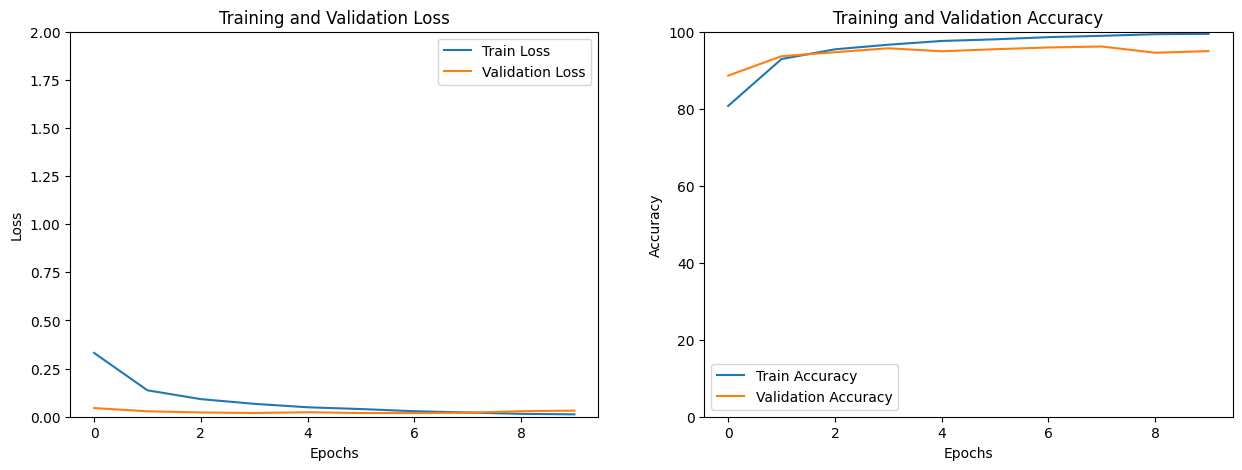

In [22]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axs[0].plot(total_loss_train_plot, label = 'Train Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title("Training and Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Train Accuracy')
axs[1].plot(total_acc_validation_plot, label = 'Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.show()